# Demonstration of Generation Pipeline

In [2]:
import time 
import numpy as np
from matplotlib import pyplot as plt
import os
import subprocess
from sklearn import cluster
from utils import *
import pandas as pd
from analyze_pore_samples.plotting_utils import frame_tick, set_axes_equal,animate_data, improve_pairplot
from analyze_pore_samples.analyze_porosity_clean import load_data, analyze_boundaries, process_images, replace_boundary
from make_surface.generate_surfaces import generate_surface
from reconstruction.pipeline_clean import load_boundary, analyze_results, trim_boundary, plot_image

/home/cmu/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


use torch backend
use torch backend


## Load CT scan data

The first step in the process is to load the stack of .tiff images, and perform preprocessing. During this stage, the sample resolution and angle of rotation are used to convert from voxel units to physical measurements. 

Several image stacks are used for further processing. ```imstack_test``` contains the combined surface roughness and pore_images, while ```pore_stack``` contains only the porosity, and ```boundary_stack``` only contains the boundary of the part. 

199it [00:03, 64.46it/s]


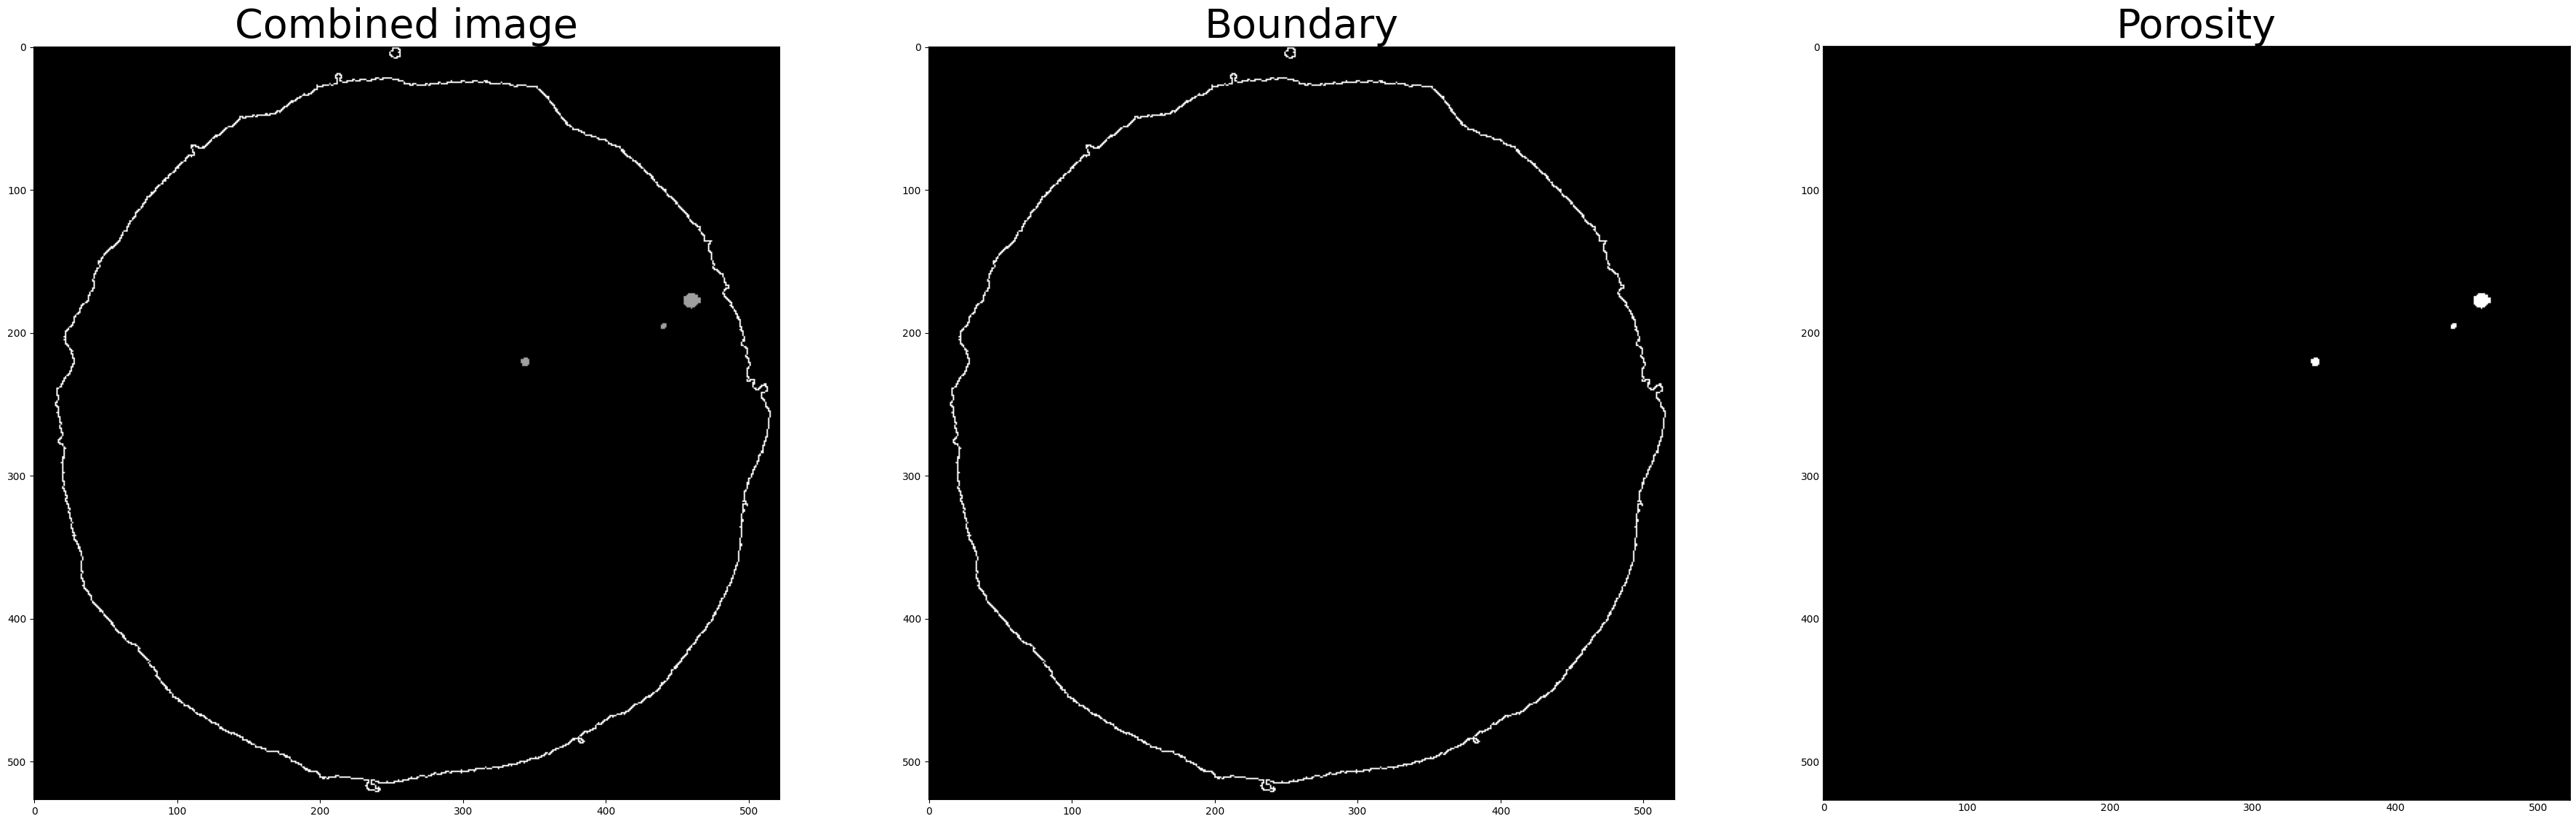

In [3]:
%matplotlib inline
folder_index = 0 # Index of part to be analyzed
frame_number = 200 # Number of frames to analyze, most parts have 2000 - 3000 frames depending on resolution
rootdir = './sample_dataset'
subfolders = [ f.path for f in os.scandir(rootdir) if f.is_dir() ]
voxelsizes = np.loadtxt('./sample_dataset/VoxelSize.txt', skiprows = 1, dtype= 'str')
voxelsizes = dict(voxelsizes)
voxelsize, imstack_test, _, _  = load_data(folder_index = folder_index, num = frame_number)
pore_stack, boundary_stack = replace_boundary(imstack_test)

fig, ax = plt.subplots(1,3, dpi = 100, figsize = np.array([9,4])*5)

ax[0].imshow(imstack_test[:,:,0], cmap = 'gist_gray')
ax[0].set_title("Combined image", fontsize = 40)
ax[1].imshow(boundary_stack[:,:,0], cmap = 'gist_gray')
ax[1].set_title("Boundary", fontsize = 40)
ax[2].imshow(pore_stack[:,:,0], cmap = 'gist_gray')
ax[2].set_title("Porosity", fontsize = 40)
frame_tick()
plt.savefig('data_example.png')
plt.show()

## Calculate surface roughness details

Next, the 2-D surface roughness profile is extracted from the boundaries, by converting to polar coordinates and storing the fluctuation in radius as a function of $r$ and $z$. This process is shown for a fragment of 500 frames below.

In [4]:
%matplotlib inline
profilometry = analyze_boundaries(k = 0, limit = 500, data_info = (voxelsize, imstack_test))

theta = np.linspace(0, 2*np.pi, profilometry.shape[1])
z = np.linspace(0, profilometry.shape[0]*voxelsize,profilometry.shape[0])
thetas, zs = np.meshgrid(theta,z)


Processing boundaries ...


499it [00:07, 63.44it/s]


processed 0 samples out of 500
29.69734215736389 time in seconds


### Plot surface roughness profile

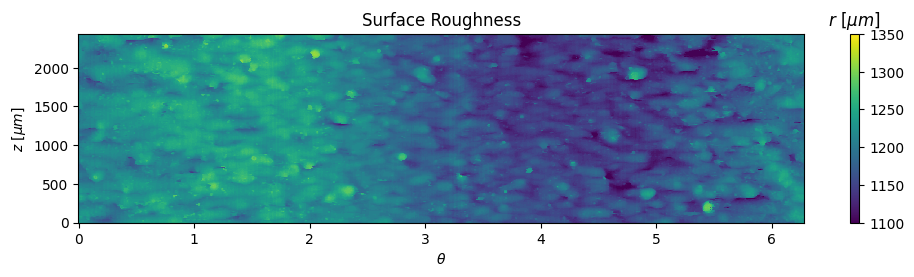

In [5]:
plt.figure(dpi = 100, figsize = np.array([profilometry.shape[1], profilometry.shape[0]])/200)
plt.pcolormesh(thetas,zs, profilometry*voxelsize, cmap = 'viridis',shading = 'auto', vmin = 1100, vmax = 1350)
clb = plt.colorbar()
clb.ax.set_title(r'$r$ $ [\mu m]$')
ax = plt.gca()
# ax.axes.set_aspect(profilometry.shape[1]/profilometry.shape[0])
# plt.imshow(profilometry, cmap = 'viridis', extent = [0, 2*np.pi, 0, profilometry.shape[0]*voxelsize])
plt.axis()
plt.title('Surface Roughness')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$z$ $ [\mu m]$ ')
plt.show()

## Extract pore probability estimates and pore information

The individual pores are extracted from the overall part sample, and the relevant statistics are extracted. ```all_pores``` contains the list of pore objects, while ```dict_properties``` contains a pandas dataframe of pore properties. Additionally, information required for the reconstruction process is saved under ```analyze_pore_samples/results/pore_properties```.

In [6]:
dict_properties, all_pores = process_images(k = 0, frame_window = frame_number, shift = frame_number//2, save = True, save_pores = True, data_info = (voxelsize, imstack_test))


Processing pores, index = 0 out of 200 ...
Pore processed: 0 pores out of 855 pores...
1904 could not broadcast input array from shape (27,75,57) into shape (27,5,57)
Pore processed: 50 pores out of 855 pores...
Saving pores  100
Pore processed: 100 pores out of 855 pores...
Pore processed: 150 pores out of 855 pores...
Saving pores  200
Pore processed: 200 pores out of 855 pores...
Pore processed: 250 pores out of 855 pores...
Saving pores  300
Pore processed: 300 pores out of 855 pores...
Pore processed: 350 pores out of 855 pores...
Saving pores  400
Pore processed: 400 pores out of 855 pores...
Pore processed: 450 pores out of 855 pores...
Saving pores  500
Pore processed: 500 pores out of 855 pores...
Pore processed: 550 pores out of 855 pores...
Saving pores  600
Pore processed: 600 pores out of 855 pores...
Pore processed: 650 pores out of 855 pores...
Saving pores  700
Pore processed: 700 pores out of 855 pores...
Pore processed: 750 pores out of 855 pores...
Saving pores  800


In [7]:
dict_properties['rough']

[3.6870516676607608,
 2.3966570957012188,
 3.763356922307339,
 6.2177911047430845,
 2.3740679243547507,
 2.4477030048598625,
 3.1046245747271923,
 4.117885497298113,
 5.665273931569698,
 3.5951356024495102,
 3.301146521948852,
 2.226087427388017,
 4.9818273755721405,
 4.749206348170187,
 6.705667379165179,
 2.148461968678454,
 5.02349758909882,
 7.5747474174060745,
 3.8378378821121406,
 2.4199690080660123,
 5.090082115005612,
 3.588462491564255,
 2.191671379906212,
 3.402284101802053,
 2.879734620477206,
 5.042853691750474,
 6.519201925849513,
 2.3221688912253993,
 3.927815338497131,
 4.598301843429029,
 2.482363261088111,
 1.8314073097962125,
 3.9247689024323456,
 3.4198747578493283,
 2.1807251338430986,
 2.6403804620499294,
 5.101357011558298,
 2.955688371598062,
 6.001021919116304,
 3.854321658786199,
 11.59357820624011,
 4.139880479026277,
 3.760834141184639,
 5.004036456639279,
 9.676511032405624,
 1.9450542248225369,
 2.570475393774467,
 1.6471318585271186,
 5.608448426258371,
 1

Here, we visualize the bivariate relationships present in the original part

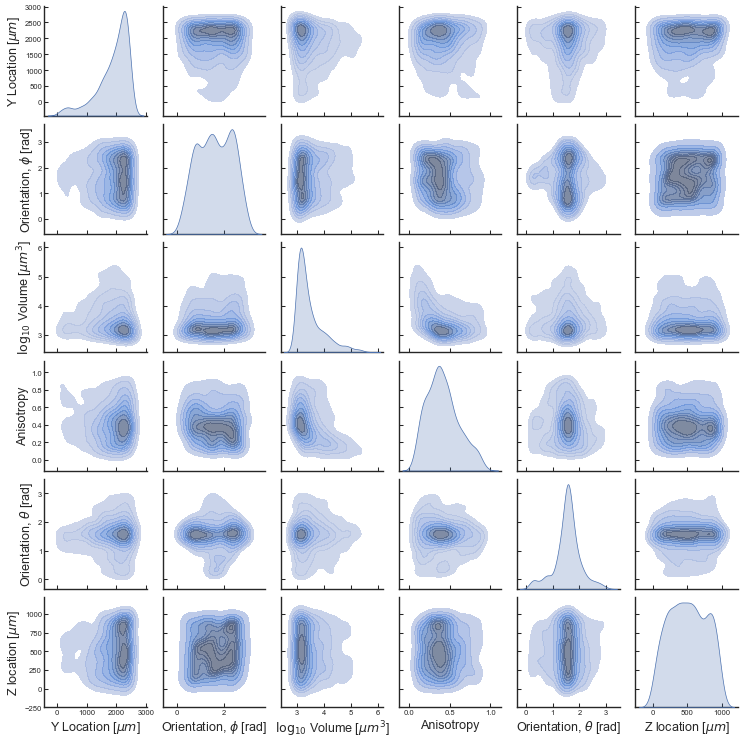

In [9]:
replacements= {'x_locs': 'X Location [$\mu m$]', 'y_locs': 'Y Location [$\mu m$]', 'z_locs': 'Z location [$\mu m$]', 'maj_axis_l': 'Major Axis Length', 'vols': r'$\log_{10} $ Volume [$\mu m^3$]',
                    'anisotropies':'Anisotropy', 'orientations': r'Orientation, $\theta$ [rad]', 'phis': r'Orientation, $\phi$ [rad]'}

import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd
pores_df = pd.DataFrame(dict_properties)
pores_df= pores_df.drop(columns=pores_df.columns[0])
pores_df['vols'] = np.log10(pores_df['vols'])
pores_df = pores_df.drop(['maj_axis_l', 'surf_dist', 'rough', 'surf_angles'], axis = 1)
g = sns.pairplot(pores_df, kind = 'kde', plot_kws = {'fill': True, 'alpha':0.7}, palette = {'Ground Truth': '#ff7f0e', 'Reconstructed': '#1f77b4'})
improve_pairplot(g, replacements)


### Coarse-grained probability matrix

The conditional probability of the pore properties, dependent on the cross-sectional area is used later on in the reconstruction process. These quantities are extracted from the original data, a sample density matrix for the number of pores in a given bin is shown below.

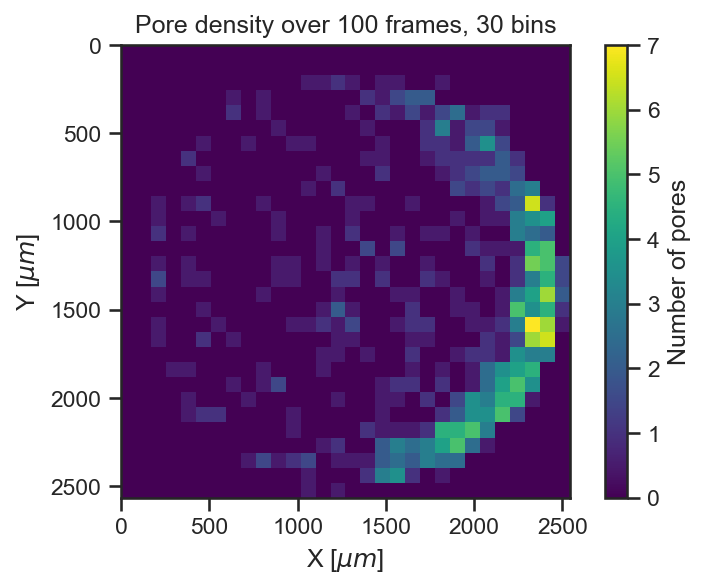

In [10]:
%matplotlib inline
properties_folder = './analyze_pore_samples/results/pore_properties/probability_matrices/'
n_bins = 30
window_size =100
plt.figure(dpi = 150)
prob_matrix_num =  np.load(properties_folder + str(n_bins) + '_{}allprob_matrix_num.npy'.format(0))*(window_size/100)
plt.title("Pore density over 100 frames, 30 bins")

plt.imshow(prob_matrix_num, cmap = 'viridis', extent = [0, imstack_test.shape[1]*voxelsize, imstack_test.shape[0]*voxelsize,0])
clb = plt.colorbar()
clb.ax.set_ylabel('Number of pores')
plt.xlabel(r"X [$\mu m$]")
plt.ylabel("Y [$\mu m$]")
plt.show()

## Generate samples from GAN

Next, a GAN model can be used to generate new pores from the existing distribution of pores. A pre-trained model, trained for 38 epochs on 165 000 pores is included with this repository. The statistics of the reconstruction for $N$ generated and $N$ extracted pores are shown below, where $N$ is the number of pores extracted from the fragment studied above.

Epoch,  38
cuda:0  will be used.

Removing previously generated pores
0 pores processed
100 pores processed
200 pores processed
300 pores processed
400 pores processed
500 pores processed
600 pores processed
700 pores processed
800 pores processed
900 pores processed
1000 pores processed
1100 pores processed
1200 pores processed
1300 pores processed
1400 pores processed
1500 pores processed
1600 pores processed
1700 pores processed
1800 pores processed
1900 pores processed
2000 pores generated, saved in  ./reconstruction/gan/saved_generated_pores/


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

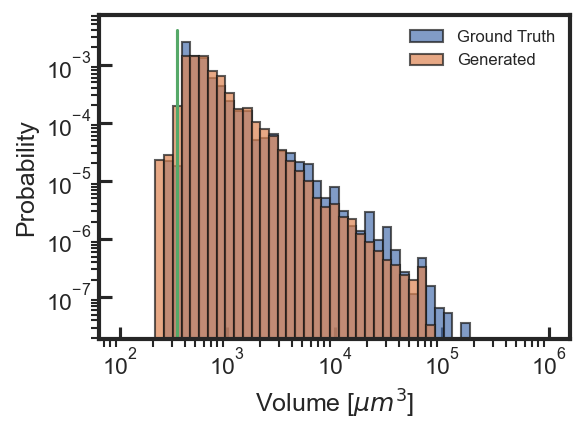

<Figure size 432x288 with 0 Axes>

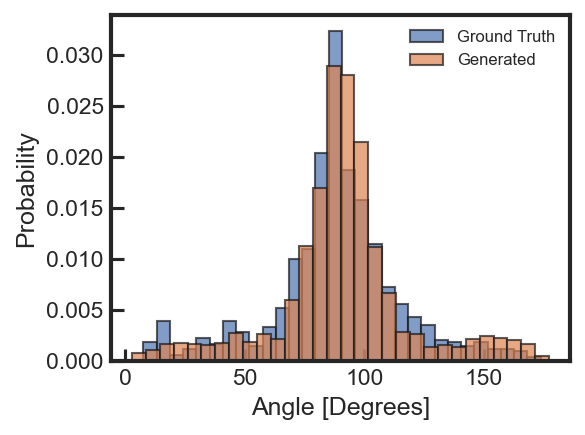

<Figure size 432x288 with 0 Axes>

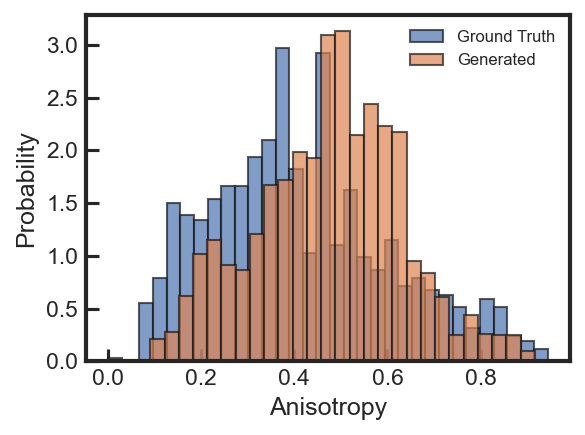

<Figure size 432x288 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

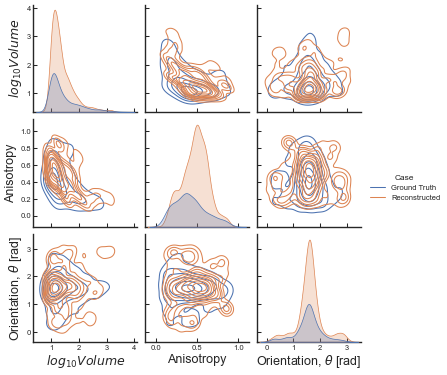

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline
from reconstruction.pore_generate import test_generator
plt.close('all')
test_generator(num_samples = 2000, folder_index = 0, show = True)

## Generate surface roughness

Following the generation of new individual pores, the next step is to generate the surface roughness, using the MST based micro-canonical model. This process is GPU-intensive and takes 10-15 minutes, so a sample generated roughness profile is also included with this repository. ```torch<=1.7.1``` is required to run the optimization process. To run the generation process, set the variable ```use_saved``` to ```False```.

In [13]:
import torch
print(torch.__version__, "Torch version")
use_saved = True
total_size = 2000 # number of boundary frames to generate -- this should be close to the total number of frames in the part
profilometry = analyze_boundaries(k = 0, limit = total_size)
if not use_saved:
    generated_boundary, xmean, ymean, dict_image = generate_surface(0, im = profilometry)
else:
    generated_boundary = torch.load('./make_surface/results/sample_number_0original_folder_0/modelC_krec0_start1.pt')['tensor_opt']
    xmean = np.loadtxt('make_surface/results/sample_number_0original_folder_0/xmean0')
    ymean = np.loadtxt('make_surface/results/sample_number_0original_folder_0/ymean0')
im_opt = np.squeeze(np.array(generated_boundary.detach().cpu()+xmean+ymean))

1.8.1+cu101 Torch version
Processing boundaries ...


1999it [00:36, 54.92it/s]


processed 0 samples out of 2000
processed 500 samples out of 2000
processed 1000 samples out of 2000
processed 1500 samples out of 2000
153.52894186973572 time in seconds


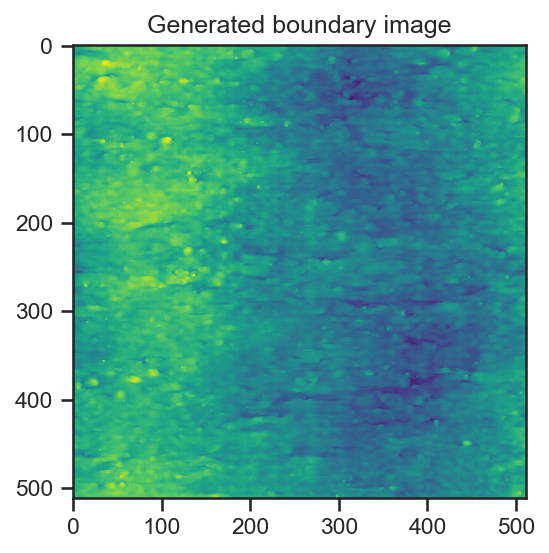

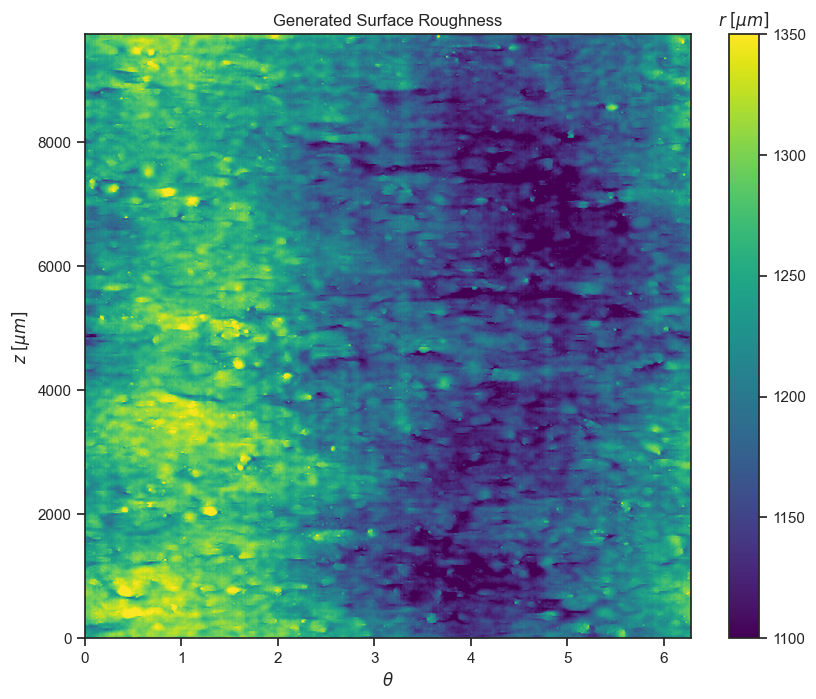

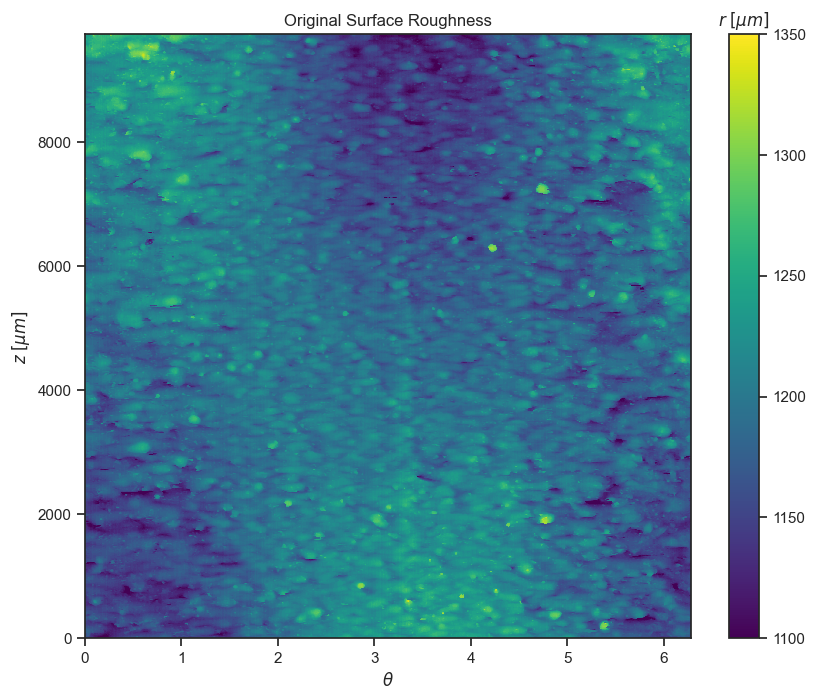

0    269.624107
Name: max, dtype: float64
0    216.839844
Name: min, dtype: float64
0


In [14]:
plt.figure(dpi = 150)
plt.imshow(im_opt, cmap = 'viridis')
plt.title("Generated boundary image")
plt.show()

from skimage.transform import resize
full_im_opt = im_opt
new_im = resize(full_im_opt, (2000, profilometry.shape[1]), order = 3)
full_image = new_im*(np.max(profilometry) - np.min(profilometry)) + np.min(profilometry)

theta = np.linspace(0, 2*np.pi, full_image.shape[1])
z = np.linspace(0, full_image.shape[0]*voxelsize,full_image.shape[0])
thetas, zs = np.meshgrid(theta,z)
plt.figure(dpi = 100, figsize = np.array([full_image.shape[1], full_image.shape[0]])/250)
plt.pcolormesh(thetas,zs, full_image*voxelsize, cmap = 'viridis',shading = 'auto', vmin = 1100, vmax = 1350)
clb = plt.colorbar()
clb.ax.set_title(r'$r$ $ [\mu m]$')
ax = plt.gca()
plt.axis()
plt.title('Generated Surface Roughness')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$z$ $ [\mu m]$ ')
plt.show()




plt.figure(dpi = 100, figsize = np.array([full_image.shape[1], full_image.shape[0]])/250)
plt.pcolormesh(thetas,zs, profilometry*voxelsize, cmap = 'viridis',shading = 'auto', vmin = 1100, vmax = 1350)
clb = plt.colorbar()
clb.ax.set_title(r'$r$ $ [\mu m]$')
ax = plt.gca()
plt.axis()
plt.title('Original Surface Roughness')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$z$ $ [\mu m]$ ')
plt.show()


generated_boundary = load_boundary(num_frames = 500, start = 0, pore_part_shape = (imstack_test.shape[0], imstack_test.shape[1]), return_profile = False)


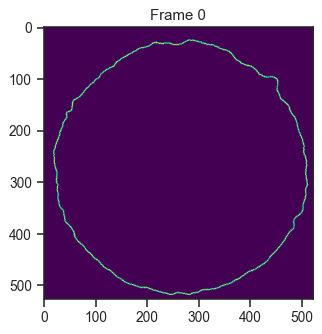

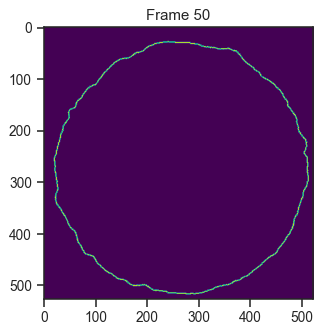

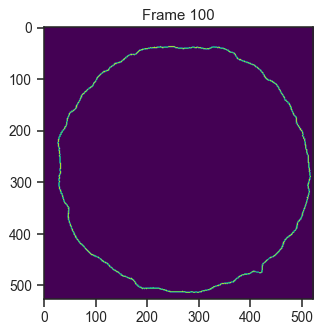

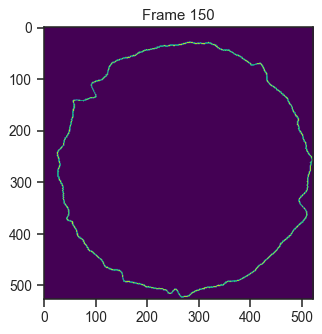

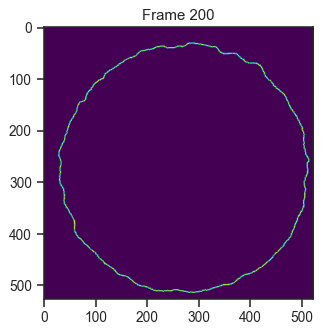

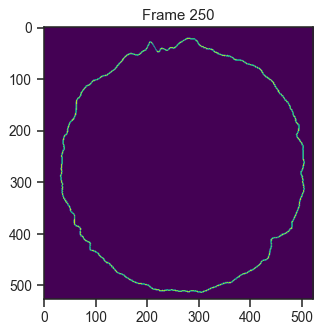

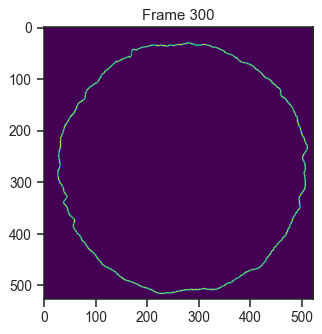

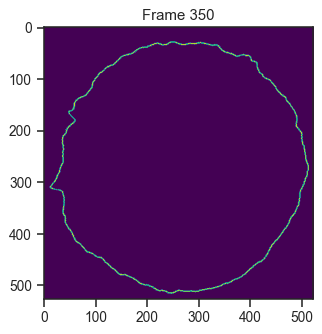

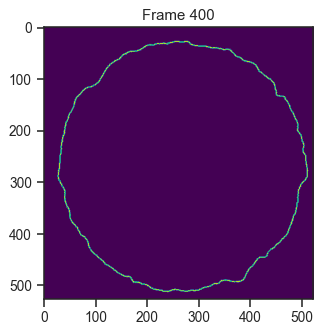

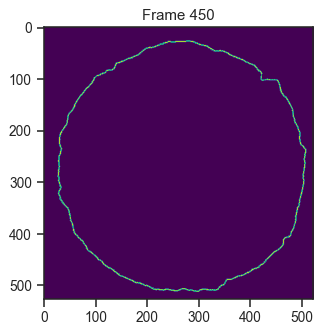

In [15]:
for i in range(10):
    plt.figure(dpi = 90)

    plt.title('Frame {}'.format(i*50))
    plt.imshow(generated_boundary[:,:,i*50], cmap = 'viridis')
    plt.show()



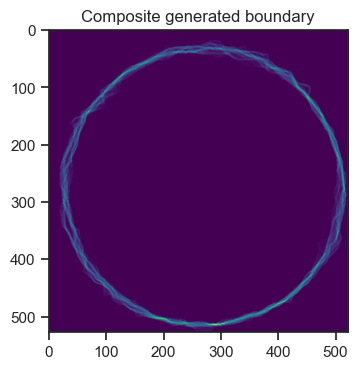

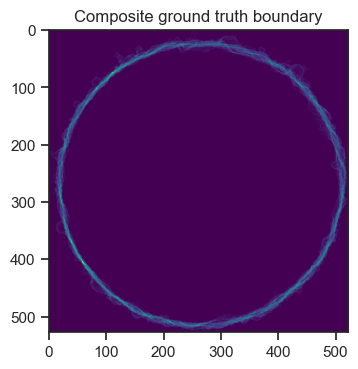

In [16]:
plt.figure(dpi = 100)
plt.title("Composite generated boundary")
plt.imshow(np.sum(generated_boundary[:,:,:frame_number],axis=2), cmap = 'viridis')
plt.show()
plt.figure(dpi = 100)

plt.title("Composite ground truth boundary")
plt.imshow(np.sum(boundary_stack[:,:,:frame_number],axis=2), cmap = 'viridis')
plt.show()

# Reconstruction of part sample

Now that the boundary and additional pore samples have been generated, the next step is to stochastically recombine these using the priors extracted from the original dataset. This process can be done on a basis of either cartesian or polar coordinates, but is demonstrated in this notebook for the cartesian case. Below, the statistics of the reconstruction will be shown. Since the reconstruction is based on the statistics extracted from the part segment, if larger sections of the part segment are analyzed for the statistics, the statistics of the generated part will be more accurate.

199it [00:03, 56.73it/s]
/home/cmu/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:9289: RuntimeWarning: invalid value encountered in true_divide
  self._hpdf = self._hpdf / float(np.sum(self._hpdf * self._hbin_widths))


continue 2 activated: pore on back surface
continue 2 activated: pore on back surface
continue 6 activated: Collision
continue 6 activated: Collision
continue 6 activated: Collision
continue 6 activated: Collision
continue 2 activated: pore on back surface
continue 6 activated: Collision
continue 2 activated: pore on back surface
continue 2 activated: pore on back surface
continue 2 activated: pore on back surface
continue 6 activated: Collision
continue 2 activated: pore on back surface
continue 2 activated: pore on back surface
continue 2 activated: pore on back surface
operands could not be broadcast together with shapes (4,0,2) (4,4,2) 
continue 4 activated: indexing exception
continue 2 activated: pore on back surface
continue 2 activated: pore on back surface
continue 6 activated: Collision
continue 2 activated: pore on back surface
operands could not be broadcast together with shapes (4,2,2) (4,4,2) 
continue 4 activated: indexing exception
continue 6 activated: Collision
contin

MemoryError: Unable to allocate 420. MiB for an array with shape (55018800,) and data type int64

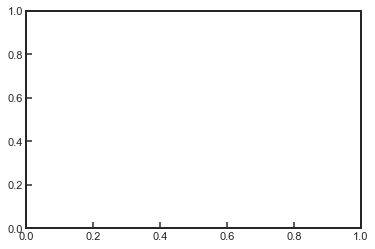

In [17]:
from reconstruction.pipeline_clean import replace_sampling, analyze_results
%matplotlib inline
pore_part = np.zeros((imstack_test.shape[0], imstack_test.shape[1], frame_number), dtype  = 'uint8')
voxelsize, imstack_test, _, _  = load_data(folder_index = 0, num = frame_number)
pore_part,_ = replace_sampling(pore_part, generated_boundary[:,:,:frame_number], n_bins = 30)
print(str(len(_)) + " pores inserted")
folder_index = 0
analyze_results(imstack_test[:,:,:frame_number], pore_part, fname = 'reconstruction/full/statistics_part_' + str(folder_index) +'/', voxelsize = voxelsize)

We then save the pore sample as ordered png images for visualization purposes. As in the original dataset, pores are represented by an intensity value of 159, while the boundary has an intensity value of 255.

In [15]:
n_bins = 30
total_frame = 0
trim_boundary(generated_boundary, pore_part)
plot_image(images = 2*pore_part, shell = generated_boundary, title = './reconstruction/full/images_generated_part_{}_bins_{}/sample/'.format(folder_index, n_bins) , global_idx =total_frame)

SAVING TO ./reconstruction/full/images_generated_part_0_bins_30/sample/


<Figure size 432x288 with 0 Axes>

In [16]:
np.sum(prob_matrix_num)*2

855.0

We can also visualize the generated part sample in 3-D. To do so, we make use of the Fiji distribution of ImageJ to stack the segmented images together. Running these cells will open an instance of ImageJ to construct and record the segment. It is important that the ImageJ window remains at the foreground during this process. An installation of Fiji is required for this to work, a .zip file is provided of the linux installation. For other installations, see the insstructions [here](https://imagej.net/software/fiji/).

In [17]:
import subprocess

command = "./Fiji.app/ImageJ-linux64  -macro ./plotting_tools/create_video.ijm "+ os.path.join(os.getcwd(),"reconstruction/full/images_generated_part_{}_bins_{}/sample/".format(folder_index, n_bins))
print(command)
subprocess.run(command, shell = True)


./Fiji.app/ImageJ-linux64  -macro ./plotting_tools/create_video.ijm /home/cmu/PorosityGenerator/reconstruction/full/images_generated_part_0_bins_30/sample/


OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
3D [dev] 1.6.0-scijava-2-pre11-daily-experimental daily



nFrames = 1


Error while executing the main() method of class 'net.imagej.Main':
java.lang.NullPointerException
	at net.imagej.legacy.IJ1Helper.setVisible(IJ1Helper.java:313)
	at net.imagej.legacy.ui.LegacyUI.show(LegacyUI.java:132)
	at org.scijava.ui.DefaultUIService.showUI(DefaultUIService.java:158)
	at org.scijava.ui.DefaultUIService.showUI(DefaultUIService.java:143)
	at org.scijava.AbstractGateway.launch(AbstractGateway.java:110)
	at net.imagej.Main.main(Main.java:55)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at net.imagej.launcher.ClassLauncher.launch(ClassLauncher.java:279)
	at net.imagej.launcher.ClassLauncher.run(ClassLauncher.java:186)
	at net.imagej.launcher.ClassLauncher.main(ClassLauncher.java:87)
X11Util.Display: Shutdown (JVM shutdown: true,

CompletedProcess(args='./Fiji.app/ImageJ-linux64  -macro ./plotting_tools/create_video.ijm /home/cmu/PorosityGenerator/reconstruction/full/images_generated_part_0_bins_30/sample/', returncode=0)

## Visualization of 3-D generated part

Note: this cell should be re-ran after running other cells in order to see the output. 

<IPython.core.display.Javascript object>


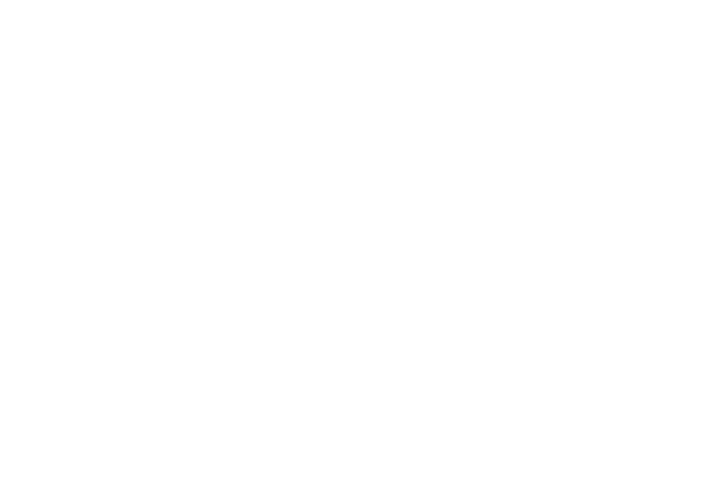

interactive(children=(IntSlider(value=179, description='degree', max=358), Output()), _dom_classes=('widget-in…

In [18]:
# Display
import ipywidgets as widgets
from ipywidgets import interact


from PIL import Image, ImageSequence
im = Image.open("./reconstruction/full/images_generated_part_{}_bins_{}/sample/Movie.gif".format(folder_index, n_bins))

generated_frames = []
index = 1
for frame in ImageSequence.Iterator(im):
    generated_frames.append(np.array(frame))
    index += 1
    
    
%matplotlib notebook
show_images = generated_frames
fig, ax = plt.subplots(dpi=150)
im = plt.imshow(generated_frames[0], cmap='gray')
plt.title("Generated Sample")
plt.xticks([])
plt.yticks([])
loop_num = np.arange(len(show_images))
@interact(degree = (loop_num[0], loop_num[-1]*2))
def show(degree):   
    im.set_array(show_images[degree//2])
    fig.canvas.draw_idle()
show(150)

We can also visualize the ground truth pores in 3-D. To do so, we make use of the Fiji distribution of ImageJ to stack the segmented images together. Running these cells will open an instance of ImageJ to construct and record the segment. It is important that the ImageJ window remains at the foreground during this process until it closes.

In [19]:
%matplotlib inline


title = 'analyze_pore_samples/results/images_part_{}_{}_frame_segment/sample/'.format(folder_index, frame_number)
name = 'images_part_{}_{}_frame_segment/sample'.format(folder_index, frame_number)
plot_image(images = pore_stack, shell = boundary_stack, title = title , global_idx =0)

command = "./Fiji.app/ImageJ-linux64  -macro ./plotting_tools/create_video.ijm "+ os.path.join(os.getcwd(),title)

print(command)
subprocess.run(command, shell = True)


SAVING TO analyze_pore_samples/results/images_part_0_200_frame_segment/sample/
./Fiji.app/ImageJ-linux64  -macro ./plotting_tools/create_video.ijm /home/cmu/PorosityGenerator/analyze_pore_samples/results/images_part_0_200_frame_segment/sample/


OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
3D [dev] 1.6.0-scijava-2-pre11-daily-experimental daily



nFrames = 1


Error while executing the main() method of class 'net.imagej.Main':
java.lang.NullPointerException
	at net.imagej.legacy.IJ1Helper.setVisible(IJ1Helper.java:313)
	at net.imagej.legacy.ui.LegacyUI.show(LegacyUI.java:132)
	at org.scijava.ui.DefaultUIService.showUI(DefaultUIService.java:158)
	at org.scijava.ui.DefaultUIService.showUI(DefaultUIService.java:143)
	at org.scijava.AbstractGateway.launch(AbstractGateway.java:110)
	at net.imagej.Main.main(Main.java:55)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at net.imagej.launcher.ClassLauncher.launch(ClassLauncher.java:279)
	at net.imagej.launcher.ClassLauncher.run(ClassLauncher.java:186)
	at net.imagej.launcher.ClassLauncher.main(ClassLauncher.java:87)
X11Util.Display: Shutdown (JVM shutdown: true,

CompletedProcess(args='./Fiji.app/ImageJ-linux64  -macro ./plotting_tools/create_video.ijm /home/cmu/PorosityGenerator/analyze_pore_samples/results/images_part_0_200_frame_segment/sample/', returncode=1)

<Figure size 432x288 with 0 Axes>

## Visualization of 3-D ground truth fragment

Note: this cell should be re-ran after running other cells in order to see the output. 

<IPython.core.display.Javascript object>


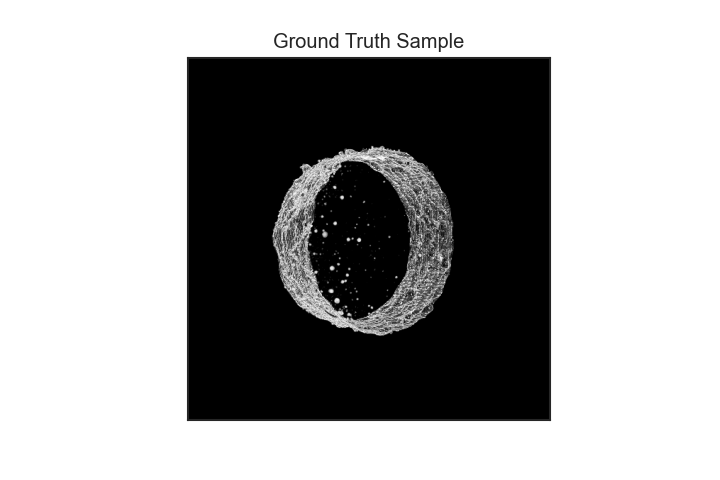

interactive(children=(IntSlider(value=179, description='degree', max=358), Output()), _dom_classes=('widget-in…

In [20]:
# Display
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib notebook

from PIL import Image, ImageSequence
im = Image.open(title + "Movie.gif".format(folder_index, frame_number))

generated_frames = []
index = 1
for frame in ImageSequence.Iterator(im):
    generated_frames.append(np.array(frame))
    index += 1
    
    
%matplotlib notebook
show_images = generated_frames
fig, ax = plt.subplots(dpi=150)
im = plt.imshow(generated_frames[0], cmap='gist_gray')
plt.title("Ground Truth Sample")
plt.xticks([])
plt.yticks([])
loop_num = np.arange(len(show_images))
@interact(degree = (loop_num[0], loop_num[-1]*2))
def show(degree):   
    im.set_array(show_images[degree//2])
    fig.canvas.draw_idle()
show(150)